In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime

# Set display options
pd.set_option('display.max_columns', None)

In [28]:
# Load the data
train_data = pd.read_excel('Train.xlsx')
test_data = pd.read_csv('Test.csv')

In [29]:
train_data.head()

,TYPE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude,HOUR,MINUTE,YEAR,MONTH,DAY,Date
0,Other Theft,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,16.0,15.0,1999,5,12,1999-05-12
1,Other Theft,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,15.0,20.0,1999,5,7,1999-05-07
2,Other Theft,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,16.0,40.0,1999,4,23,1999-04-23
3,Other Theft,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,11.0,15.0,1999,4,20,1999-04-20
4,Other Theft,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,17.0,45.0,1999,4,12,1999-04-12


In [30]:
test_data.head()

,YEAR,MONTH,TYPE,Incident_Counts
0,2013,6,Vehicle Collision or Pedestrian Struck (with I...,NaN
1,2013,6,Theft of Vehicle,NaN
2,2013,6,Theft of Bicycle,NaN
3,2013,6,Theft from Vehicle,NaN
4,2013,6,Other Theft,NaN


In [31]:
# Check for missing values
print(train_data.isnull().sum())

TYPE                 0
HUNDRED_BLOCK       13
NEIGHBOURHOOD    51491
X                    0
Y                    0
Latitude             0
Longitude            0
HOUR             49365
MINUTE           49365
YEAR                 0
MONTH                0
DAY                  0
Date                 0
dtype: int64


In [49]:
# Aggregate data to monthly level
monthly_data = train_data.groupby(['YEAR', 'MONTH', 'TYPE']).size().reset_index(name='Incident_Counts')

In [50]:
monthly_data.head()

,YEAR,MONTH,TYPE,Incident_Counts
0,1999,1,Break and Enter Commercial,303
1,1999,1,Break and Enter Residential/Other,644
2,1999,1,Mischief,551
3,1999,1,Offence Against a Person,338
4,1999,1,Other Theft,247


In [34]:
# Check for missing values
print(monthly_data.isnull().sum())

YEAR               0
MONTH              0
TYPE               0
Incident_Counts    0
dtype: int64


In [51]:
# Encode categorical variables
le = LabelEncoder()
monthly_data['TYPE_code'] = le.fit_transform(monthly_data['TYPE'])

In [66]:
monthly_data.head(10)

,YEAR,MONTH,TYPE,Incident_Counts,TYPE_code
0,1999,1,Break and Enter Commercial,303,0
1,1999,1,Break and Enter Residential/Other,644,1
2,1999,1,Mischief,551,2
3,1999,1,Offence Against a Person,338,3
4,1999,1,Other Theft,247,4
5,1999,1,Theft from Vehicle,1438,5
6,1999,1,Theft of Bicycle,96,6
7,1999,1,Theft of Vehicle,640,7
8,1999,1,Vehicle Collision or Pedestrian Struck (with I...,139,8
9,1999,2,Break and Enter Commercial,254,0


In [53]:
# Splitting data into training and validation sets
X = monthly_data.drop(columns=['Incident_Counts','TYPE'])
y = monthly_data['Incident_Counts']

In [54]:
# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

In [65]:
X_train

,YEAR,MONTH,TYPE_code
0,1999,1,0
1,1999,1,1
2,1999,1,2
3,1999,1,3
4,1999,1,4
...,...,...,...
1118,2009,5,2
1119,2009,5,3
1120,2009,5,4
1121,2009,5,5


In [64]:
# Define RMSE as the scoring metric
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Define model parameter grids
param_grids = {
    'RandomForest': {
        'n_estimators': [5, 10, 25, 50, 100, 200, 500],
        'max_depth': [None, 10, 20, 30, 50],
    },
    'GradientBoosting': {
        'n_estimators': [5, 10, 25, 50, 100, 200, 500],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 10, 15],
    },
    'XGBoost': {
        'n_estimators': [5, 10, 25, 50, 100, 200, 500],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 10, 15],
    }
}

# Initialize models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Dictionary to store best models and their RMSEs
best_models = {}
best_rmse = {}

# GridSearchCV for each model
for name, model in models.items():
    print(f"Optimizing {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=tscv, scoring=rmse_scorer, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model and its RMSE
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

    # Store the best model and RMSE
    best_models[name] = best_model
    best_rmse[name] = rmse

    print(f"Best {name} model: {best_model}")
    print(f"Best {name} RMSE: {rmse}\n")


Optimizing RandomForest...
Best RandomForest model: RandomForestRegressor(n_estimators=5, random_state=42)
Best RandomForest RMSE: 88.48116915690967

Optimizing GradientBoosting...
Best GradientBoosting model: GradientBoostingRegressor(learning_rate=0.01, n_estimators=5, random_state=42)
Best GradientBoosting RMSE: 213.04781064884745

Optimizing XGBoost...
Best XGBoost model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
    

Best overall model: RandomForest with RMSE: 88.48116915690967


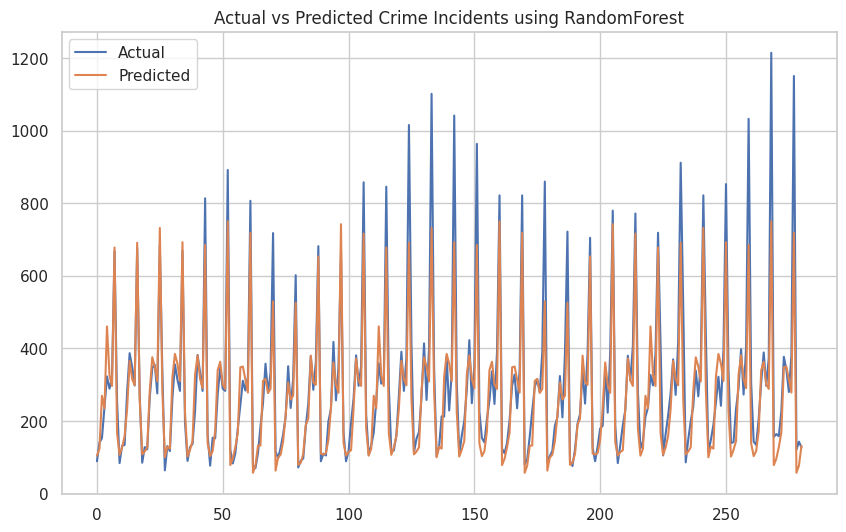

In [67]:
# Select the best model based on RMSE
best_model_name = min(best_rmse, key=best_rmse.get)
best_model = best_models[best_model_name]

print(f"Best overall model: {best_model_name} with RMSE: {best_rmse[best_model_name]}")

# Predict on validation set
y_pred_best = best_model.predict(X_valid)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_valid.values, label='Actual')
plt.plot(y_pred_best, label='Predicted')
plt.title(f'Actual vs Predicted Crime Incidents using {best_model_name}')
plt.legend()
plt.show()

In [69]:
# Prepare test data similar to train data
test_features = test_data.drop(columns='Incident_Counts')
test_features['TYPE_code'] = le.transform(test_features['TYPE'])

# Generate predictions
test_data['Incident_Counts'] = best_model.predict(test_features.drop('TYPE', axis=1))

# Submission
test_data['Incident_Counts'].to_csv('submission.csv', index=False)